# Information Retrieval and Web Analytics

# Indexing + Modeling (TF-IDF)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time

In [3]:
# if you do not have 'nltk', the following command should work "python -m pip install nltk"
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
tweets_path = '/content/drive/MyDrive/RIAW/data/farmers-protest-tweets.json'
tweet_doc_ids_map_path = '/content/drive/MyDrive/RIAW/data/tweet_document_ids_map.csv'

In [5]:
import json
import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


# Load the JSON dataset line by line
tweets_data = []
with open(tweets_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Each line is a separate JSON object
        tweets_data.append(json.loads(line))


# Load the tweet-to-document ID map
tweet_doc_ids_map = pd.read_csv(tweet_doc_ids_map_path)

# Convert the mapping into a dictionary for fast lookups (tweet_id -> document_id)
tweet_to_doc_map = dict(zip(tweet_doc_ids_map['id'], tweet_doc_ids_map['docId']))

# Function to preprocess tweet content
def build_terms(line):
    """
    Preprocess the tweet content by removing stop words, punctuation, and applying stemming.

    Argument:
    line -- string (text to preprocess)

    Returns:
    A list of tokens corresponding to the preprocessed text.
    """
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    # Convert to lowercase
    line = line.lower()

    # Remove punctuation (except for #)
    line = line.translate(str.maketrans('', '', string.punctuation.replace('#', '')))

    # Tokenize the text
    line = line.split()

    # Remove stopwords
    line = [word for word in line if word not in stop_words]

    # Apply stemming
    line = [stemmer.stem(word) for word in line]

    return line

# Function to extract hashtags from the tweet
def extract_hashtags(text):
    """
    Extracts hashtags from the tweet content.

    Argument:
    text -- string (tweet content)

    Returns:
    hashtags - a list of hashtags found in the tweet
    """
    hashtags = re.findall(r'#\w+', text)  # Find hashtags using regular expressions
    return hashtags

# Function to process a tweet and return the required structure
def process_tweet(tweet):
    """
    Processes a single tweet and returns the required information structure, including document ID.

    Argument:
    tweet -- dictionary containing tweet data

    Returns:
    processed_tweet -- dictionary with the tweet's preprocessed content and metadata
    """
    tweet_id = tweet['id']  # Get the tweet ID

    # Fetch the document ID mapped to this tweet ID
    document_id = tweet_to_doc_map.get(tweet_id, None)

    tweet_content = tweet['content']  # Get the tweet content

    # Preprocess the tweet content
    preprocessed_content = build_terms(tweet_content)

    # Extract hashtags
    hashtags = extract_hashtags(tweet_content)

    # Structure the final output
    processed_tweet = {
        'Tweet': ' '.join(preprocessed_content),  # Preprocessed tweet content
        'Date': tweet['date'],
        'Hashtags': hashtags,
        'Likes': tweet['likeCount'],
        'Retweets': tweet['retweetCount'],
        'Url': tweet['url']
    }

    return document_id, processed_tweet

# Dictionary to store the results
doc_tweet_map = {}

# Process all tweets and store them in a dictionary of dictionaries
for tweet in tweets_data:
    document_id, processed_tweet = process_tweet(tweet)

    if document_id:  # Ensure the tweet has a valid document ID
        # Store the processed tweet under the document ID
        doc_tweet_map[document_id] = processed_tweet

# Example: Print the dictionary for the first few document IDs
for doc_id, tweet_info in list(doc_tweet_map.items())[:5]:
    print(f"Doc ID: {doc_id}\nTweet Info: {tweet_info}\n")


Doc ID: doc_0
Tweet Info: {'Tweet': 'world progress indian polic govt still tri take india back horrif past tyranni narendramodi delhipolic shame #modidontsellfarm #farmersprotest #freenodeepkaur httpstcoes3kn0iqaf', 'Date': '2021-02-24T09:23:35+00:00', 'Hashtags': ['#ModiDontSellFarmers', '#FarmersProtest', '#FreeNodeepKaur'], 'Likes': 0, 'Retweets': 0, 'Url': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198'}

Doc ID: doc_1
Tweet Info: {'Tweet': '#farmersprotest #modiignoringfarmersdeath #modidontsellfarm kisanektamorcha farmer constantli distroy crop throughout india realli heart breakingw care crop like children govt agricultur minist laugh us🚜🌾w win💪 httpstcoklspngg9x', 'Date': '2021-02-24T09:23:32+00:00', 'Hashtags': ['#FarmersProtest', '#ModiIgnoringFarmersDeaths', '#ModiDontSellFarmers'], 'Likes': 0, 'Retweets': 0, 'Url': 'https://twitter.com/PrdeepNain/status/1364506237451313155'}

Doc ID: doc_2
Tweet Info: {'Tweet': 'reallyswara rohinisgh watch full video https

Vocabulary size: 79157
Average tweet length (in words): 14.985483904272234
Average tweet length (in characters): 132.4425447562411
Most common words: [('#farmersprotest', 49819), ('farmer', 15333), ('india', 6192), ('support', 5953), ('protest', 4663), ('amp', 4248), ('right', 3540), ('peopl', 3457), ('indian', 2895), ('govern', 2662), ('modi', 2593), ('law', 2523), ('#releasedetainedfarm', 2422), ('govt', 2283), ('stand', 2196), ('bjp', 2151), ('#farmersmakeindia', 2118), ('#indiabeingsilenc', 2115), ('thank', 2106), ('pleas', 2040)]


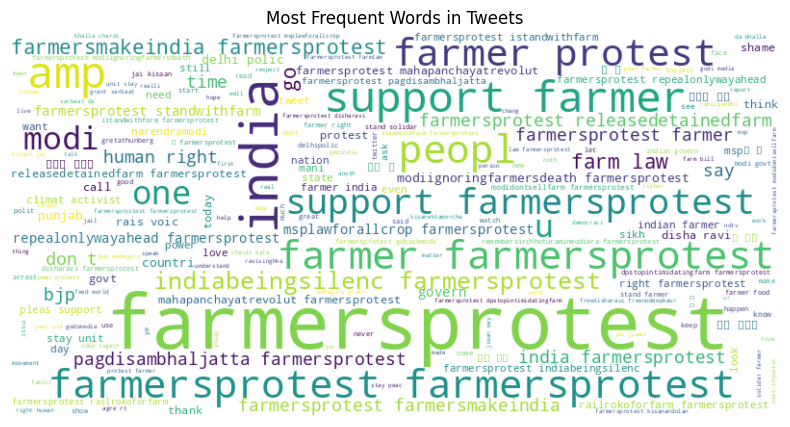

'Top 5 Most Retweeted Tweets:\n'

,date,content,likeCount,retweetCount,url
111329,2021-02-12T10:10:56+00:00,मध्यप्रदेश में निजी व्यापारी 200 करोड़ का धान ...,25824,7723,https://twitter.com/RakeshTikaitBKU/status/136...
7645,2021-02-23T09:40:21+00:00,There's a #FarmersProtest happening in Germany...,27888,6164,https://twitter.com/dhruv_rathee/status/136414...
89780,2021-02-14T09:22:23+00:00,"disha ravi, a 21-year-old climate activist, ha...",8974,4673,https://twitter.com/rupikaur_/status/136088206...
88911,2021-02-14T11:07:50+00:00,Disha Ravi broke down in court room and told j...,10403,3742,https://twitter.com/amaanbali/status/136090860...
111556,2021-02-12T09:44:31+00:00,Farmers are so sweet. Y’all have to see this @...,17325,3332,https://twitter.com/jedijasmin_/status/1360162...


Most common hashtags: [('#farmersprotest', 50418), ('#releasedetainedfarm', 2439), ('#indiabeingsilenc', 2146), ('#farmersmakeindia', 2139), ('#disharavi', 2004), ('#mahapanchayatrevolut', 1952), ('#repealonlywayahead', 1764), ('#pagdisambhaljatta', 1590), ('#farmer', 1525), ('#standwithfarm', 1389)]


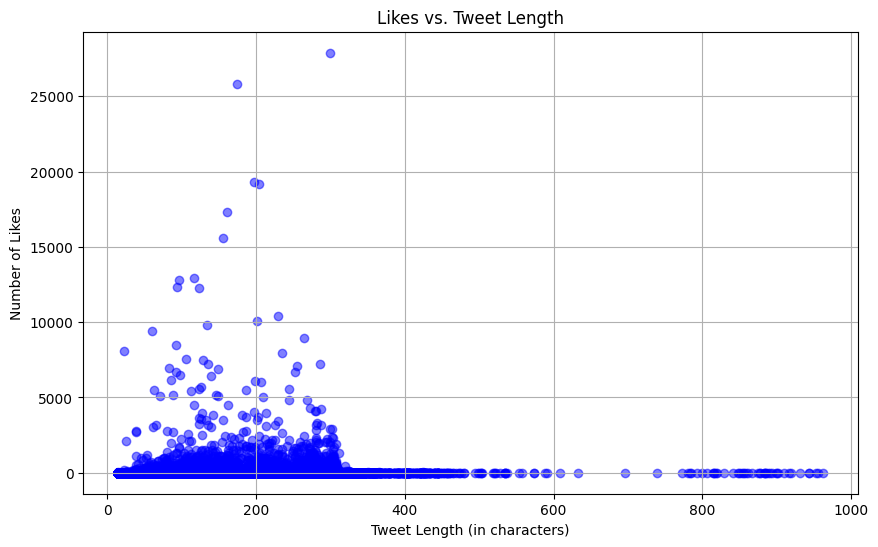

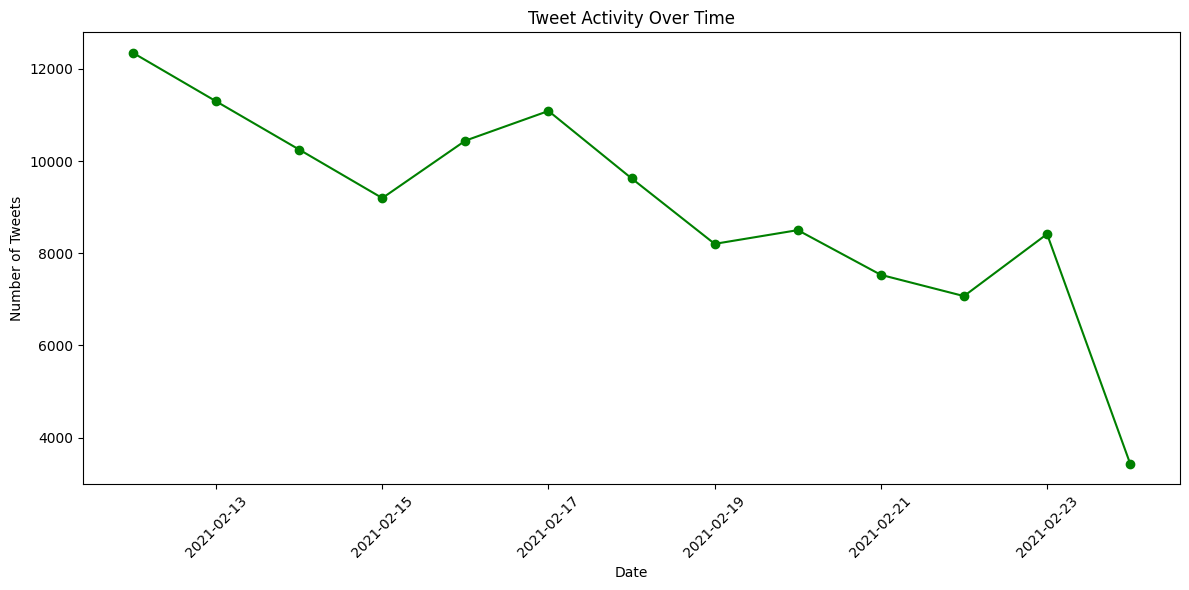

In [6]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import pandas as pd


# 1. Vocabulary Size
# Let's use the preprocessed tweets already in doc_tweet_map
all_tweets_content = [doc_tweet_map[doc]['Tweet'] for doc in doc_tweet_map]
all_words = ' '.join(all_tweets_content).split()

vocabulary_size = len(set(all_words))
print(f"Vocabulary size: {vocabulary_size}")

# 2. Average Tweet Length (in words and characters)
average_tweet_length_words = sum(len(tweet.split()) for tweet in all_tweets_content) / len(all_tweets_content)
average_tweet_length_chars = sum(len(tweet) for tweet in all_tweets_content) / len(all_tweets_content)

print(f"Average tweet length (in words): {average_tweet_length_words}")
print(f"Average tweet length (in characters): {average_tweet_length_chars}")

# 3. Most Frequent Words
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)
print("Most common words:", most_common_words)

# 4. Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Tweets")
plt.show()

# 5. Most Retweeted Tweets
tweets_df = pd.DataFrame(tweets_data)  # Using the original dataset
most_retweeted = tweets_df[['date','content','likeCount', 'retweetCount', 'url']].sort_values(by='retweetCount', ascending=False).head(5)
display("Top 5 Most Retweeted Tweets:\n", most_retweeted)

# 6. Hashtag Analysis
def extract_hashtags_from_processed_tweets(text):
    return re.findall(r"#\w+", text)

# Extract hashtags from the already processed tweets
all_hashtags = [hashtag for tweet in all_tweets_content for hashtag in extract_hashtags_from_processed_tweets(tweet)]
hashtag_freq = Counter(all_hashtags)
most_common_hashtags = hashtag_freq.most_common(10)
print("Most common hashtags:", most_common_hashtags)


import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


# Convert the list of tweets to a DataFrame
tweets_df = pd.DataFrame(tweets_data)

# 7. Calculate the length of each tweet
tweets_df['tweet_length'] = tweets_df['content'].apply(len)

# Scatter plot for Likes vs. Tweet Length
plt.figure(figsize=(10, 6))
plt.scatter(tweets_df['tweet_length'], tweets_df['likeCount'], alpha=0.5, color='blue')
plt.title("Likes vs. Tweet Length")
plt.xlabel("Tweet Length (in characters)")
plt.ylabel("Number of Likes")
plt.grid(True)
plt.show()


# 8. Time-based Analysis of Tweet Activity

# Convert the 'date' column to datetime
tweets_df['date'] = pd.to_datetime(tweets_df['date'])

# Group the data by date and count the number of tweets per day
tweets_per_day = tweets_df.groupby(tweets_df['date'].dt.date).size()

# Plot the number of tweets over time
plt.figure(figsize=(12, 6))
tweets_per_day.plot(kind='line', color='green', marker='o')
plt.title("Tweet Activity Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()